In [1]:
# Install the necessary packages
# Uncomment this line if you haven't installed the packages
# !pip install openfermion openfermionpyscf py3Dmol
# Qiskit imports
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.primitives import StatevectorEstimator as Estimator, StatevectorSampler as Sampler

# General imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

# Import necessary libraries
import numpy as np
from openfermion.ops import FermionOperator
from openfermion.transforms import jordan_wigner
from openfermionpyscf import generate_molecular_hamiltonian
from openfermion.linalg import get_sparse_operator  # Updated import for sparse operator conversion
import py3Dmol  # For molecule visualization

# Notebook setup
from IPython.display import display, Markdown

# Function to display intermediate steps in Markdown format
def display_step(step_text):
    display(Markdown(f"### {step_text}"))

# Function to visualize the H2 molecule
def visualize_h2_molecule():
    # Create a molecule object in py3Dmol
    xyz = """
    H 0.0 0.0 0.0
    H 0.0 0.0 0.74
    """
    

# Step 1: Define the H2 molecule geometry and basis set
display_step("Step 1: Define the H₂ molecule geometry and basis set")
geometry = [('H', (0, 0, 0)), ('H', (0, 0, 0.74))]  # Bond distance ~0.74 Å
basis = 'sto-3g'  # Minimal basis set
multiplicity = 1  # Singlet state (closed shell)
charge = 0  # Neutral H₂ molecule

display_step(f"Defined geometry: {geometry}\nUsing basis: {basis}")





### Step 1: Define the H₂ molecule geometry and basis set

### Defined geometry: [('H', (0, 0, 0)), ('H', (0, 0, 0.74))]
Using basis: sto-3g

In [2]:
# Step 2: Generate the molecular Hamiltonian
display_step("Step 2: Generate the molecular Hamiltonian using OpenFermion")

molecular_hamiltonian = generate_molecular_hamiltonian(geometry, basis, multiplicity, charge)
fermionic_hamiltonian = molecular_hamiltonian

# Display the molecular Hamiltonian in FermionOperator form
display_step("Generated Fermionic Hamiltonian:")
print(fermionic_hamiltonian)



### Step 2: Generate the molecular Hamiltonian using OpenFermion

### Generated Fermionic Hamiltonian:

() 0.7151043390810812
((0, 1), (0, 0)) -1.2533097866459773
((1, 1), (1, 0)) -1.2533097866459773
((2, 1), (2, 0)) -0.47506884877217775
((3, 1), (3, 0)) -0.47506884877217775
((0, 1), (0, 1), (0, 0), (0, 0)) 0.3373779634072241
((0, 1), (0, 1), (2, 0), (2, 0)) 0.09060523100759851
((0, 1), (1, 1), (1, 0), (0, 0)) 0.3373779634072241
((0, 1), (1, 1), (3, 0), (2, 0)) 0.09060523100759851
((0, 1), (2, 1), (0, 0), (2, 0)) 0.09060523100759851
((0, 1), (2, 1), (2, 0), (0, 0)) 0.33185570067540676
((0, 1), (3, 1), (1, 0), (2, 0)) 0.09060523100759851
((0, 1), (3, 1), (3, 0), (0, 0)) 0.33185570067540676
((1, 1), (0, 1), (0, 0), (1, 0)) 0.3373779634072241
((1, 1), (0, 1), (2, 0), (3, 0)) 0.09060523100759851
((1, 1), (1, 1), (1, 0), (1, 0)) 0.3373779634072241
((1, 1), (1, 1), (3, 0), (3, 0)) 0.09060523100759851
((1, 1), (2, 1), (0, 0), (3, 0)) 0.09060523100759851
((1, 1), (2, 1), (2, 0), (1, 0)) 0.33185570067540676
((1, 1), (3, 1), (1, 0), (3, 0)) 0.09060523100759851
((1, 1), (3, 1), (3, 0), (1, 0)) 0.33

In [3]:
# Step 3: Extract h_pq and h_pqrs integrals
display_step("Step 3: Extract the one-electron (h_pq) and two-electron integrals (h_pqrs)")

# Extract the one-body (h_pq) and two-body (h_pqrs) integrals from the molecular Hamiltonian
one_body_integrals = molecular_hamiltonian.one_body_tensor
two_body_integrals = molecular_hamiltonian.two_body_tensor

# Print one-electron integrals (h_pq)
print("One-electron integrals (h_pq):")
print(one_body_integrals)

# Print two-electron integrals (h_pqrs)
print("\nTwo-electron integrals (h_pqrs):")
print(two_body_integrals)



### Step 3: Extract the one-electron (h_pq) and two-electron integrals (h_pqrs)

One-electron integrals (h_pq):
[[-1.25330979  0.          0.          0.        ]
 [ 0.         -1.25330979  0.          0.        ]
 [ 0.          0.         -0.47506885  0.        ]
 [ 0.          0.          0.         -0.47506885]]

Two-electron integrals (h_pqrs):
[[[[0.33737796 0.         0.         0.        ]
   [0.         0.         0.         0.        ]
   [0.         0.         0.09060523 0.        ]
   [0.         0.         0.         0.        ]]

  [[0.         0.         0.         0.        ]
   [0.33737796 0.         0.         0.        ]
   [0.         0.         0.         0.        ]
   [0.         0.         0.09060523 0.        ]]

  [[0.         0.         0.09060523 0.        ]
   [0.         0.         0.         0.        ]
   [0.3318557  0.         0.         0.        ]
   [0.         0.         0.         0.        ]]

  [[0.         0.         0.         0.        ]
   [0.         0.         0.09060523 0.        ]
   [0.         0.         0.         0

In [4]:
# Step 4: Jordan-Wigner Transformation
display_step("Step 4: Apply the Jordan-Wigner transformation")

jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

# Display the Jordan-Wigner transformed Hamiltonian
display_step("Jordan-Wigner Transformed Hamiltonian (Pauli Operators):")
print(jw_hamiltonian)



### Step 4: Apply the Jordan-Wigner transformation

### Jordan-Wigner Transformed Hamiltonian (Pauli Operators):

-0.09706626816763103 [] +
-0.04530261550379926 [X0 X1 Y2 Y3] +
0.04530261550379926 [X0 Y1 Y2 X3] +
0.04530261550379926 [Y0 X1 X2 Y3] +
-0.04530261550379926 [Y0 Y1 X2 X3] +
0.17141282644776915 [Z0] +
0.16868898170361205 [Z0 Z1] +
0.12062523483390411 [Z0 Z2] +
0.16592785033770338 [Z0 Z3] +
0.1714128264477691 [Z1] +
0.16592785033770338 [Z1 Z2] +
0.12062523483390411 [Z1 Z3] +
-0.22343153690813436 [Z2] +
0.17441287612261575 [Z2 Z3] +
-0.22343153690813436 [Z3]


In [5]:
# Step 5: Convert to a sparse matrix for further simulation
display_step("Step 5: Convert the Hamiltonian to a sparse matrix form for further simulation")

jw_sparse_hamiltonian = get_sparse_operator(jw_hamiltonian)  # Using the updated sparse operator method
print(jw_sparse_hamiltonian)


### Step 5: Convert the Hamiltonian to a sparse matrix form for further simulation

<Compressed Sparse Column sparse matrix of dtype 'complex128'
	with 20 stored elements and shape (16, 16)>
  Coords	Values
  (0, 0)	(0.7151043390810812+0j)
  (1, 1)	(0.24003549030890353+0j)
  (2, 2)	(0.24003549030890353+0j)
  (3, 3)	(0.4626181460271887+0j)
  (12, 3)	(0.18121046201519703+0j)
  (4, 4)	(-0.5382054475648959+0j)
  (5, 5)	(-0.5307733570014572+0j)
  (6, 6)	(-0.34956289498626014+0j)
  (9, 6)	(-0.18121046201519703+0j)
  (7, 7)	(0.35552070006764147+0j)
  (8, 8)	(-0.5382054475648961+0j)
  (6, 9)	(-0.18121046201519703+0j)
  (9, 9)	(-0.34956289498626036+0j)
  (10, 10)	(-0.5307733570014574+0j)
  (11, 11)	(0.35552070006764125+0j)
  (3, 12)	(0.18121046201519703+0j)
  (12, 12)	(-1.116759307396425+0j)
  (13, 13)	(-0.44561581548217305+0j)
  (14, 14)	(-0.44561581548217305+0j)
  (15, 15)	(0.9231791809225423+0j)


# Transform Fermionic hamiltonion to qubits under the Jordan-Wigner transformation and print its spectrum.


In [6]:
from openfermion.linalg import eigenspectrum

jw_operator = jordan_wigner(fermionic_hamiltonian)
print('')
print(jw_operator)
jw_spectrum = eigenspectrum(jw_operator)
print(jw_spectrum)



-0.09706626816763103 [] +
-0.04530261550379926 [X0 X1 Y2 Y3] +
0.04530261550379926 [X0 Y1 Y2 X3] +
0.04530261550379926 [Y0 X1 X2 Y3] +
-0.04530261550379926 [Y0 Y1 X2 X3] +
0.17141282644776915 [Z0] +
0.16868898170361205 [Z0 Z1] +
0.12062523483390411 [Z0 Z2] +
0.16592785033770338 [Z0 Z3] +
0.1714128264477691 [Z1] +
0.16592785033770338 [Z1 Z2] +
0.12062523483390411 [Z1 Z3] +
-0.22343153690813436 [Z2] +
0.17441287612261575 [Z2 Z3] +
-0.22343153690813436 [Z3]
[-1.13728383 -0.53820545 -0.53820545 -0.53077336 -0.53077336 -0.53077336
 -0.44561582 -0.44561582 -0.16835243  0.24003549  0.24003549  0.3555207
  0.3555207   0.48314267  0.71510434  0.92317918]


# Map QubitOperator to a FermionOperator


In [7]:
from openfermion.ops import QubitOperator
from openfermion.transforms import reverse_jordan_wigner

from openfermion.ops import QubitOperator

# Define the Hamiltonian using QubitOperator in OpenFermion
qubit_hamiltonian = (
    (-0.09706626816763103 + 0j) * QubitOperator('') + 
    (-0.04530261550379926 + 0j) * QubitOperator('X0 X1 Y2 Y3') + 
    (0.04530261550379926 + 0j) * QubitOperator('X0 Y1 Y2 X3') + 
    (0.04530261550379926 + 0j) * QubitOperator('Y0 X1 X2 Y3') + 
    (-0.04530261550379926 + 0j) * QubitOperator('Y0 Y1 X2 X3') + 
    (0.17141282644776915 + 0j) * QubitOperator('Z0') + 
    (0.16868898170361205 + 0j) * QubitOperator('Z0 Z1') + 
    (0.12062523483390411 + 0j) * QubitOperator('Z0 Z2') + 
    (0.16592785033770338 + 0j) * QubitOperator('Z0 Z3') + 
    (0.1714128264477691 + 0j) * QubitOperator('Z1') + 
    (0.16592785033770338 + 0j) * QubitOperator('Z1 Z2') + 
    (0.12062523483390411 + 0j) * QubitOperator('Z1 Z3') + 
    (-0.22343153690813436 + 0j) * QubitOperator('Z2') + 
    (0.17441287612261575 + 0j) * QubitOperator('Z2 Z3') + 
    (-0.22343153690813436 + 0j) * QubitOperator('Z3')
)

# Print the Qubit Hamiltonian
print("Qubit Hamiltonian:")
print(qubit_hamiltonian)

# Apply the Jordan-Wigner transformation to map qubit operators to fermion operators
fermion_hamiltonian = reverse_jordan_wigner(qubit_hamiltonian)

# Print the Fermionic Hamiltonian
print("\nFermion Hamiltonian (Jordan-Wigner Transformed):")
print(fermion_hamiltonian)


Qubit Hamiltonian:
(-0.09706626816763103+0j) [] +
(-0.04530261550379926+0j) [X0 X1 Y2 Y3] +
(0.04530261550379926+0j) [X0 Y1 Y2 X3] +
(0.04530261550379926+0j) [Y0 X1 X2 Y3] +
(-0.04530261550379926+0j) [Y0 Y1 X2 X3] +
(0.17141282644776915+0j) [Z0] +
(0.16868898170361205+0j) [Z0 Z1] +
(0.12062523483390411+0j) [Z0 Z2] +
(0.16592785033770338+0j) [Z0 Z3] +
(0.1714128264477691+0j) [Z1] +
(0.16592785033770338+0j) [Z1 Z2] +
(0.12062523483390411+0j) [Z1 Z3] +
(-0.22343153690813436+0j) [Z2] +
(0.17441287612261575+0j) [Z2 Z3] +
(-0.22343153690813436+0j) [Z3]

Fermion Hamiltonian (Jordan-Wigner Transformed):
(0.7151043390810814+0j) [] +
(-1.2533097866459775+0j) [0^ 0] +
(-1.2533097866459773+0j) [1^ 1] +
(0.6747559268144482+0j) [1^ 1 0^ 0] +
(-0.47506884877217775+0j) [2^ 2] +
(0.48250093933561644+0j) [2^ 2 0^ 0] +
(0.6637114013508135+0j) [2^ 2 1^ 1] +
(-0.18121046201519703+0j) [3 2 1^ 0^] +
(0.18121046201519703+0j) [3 2^ 1^ 0] +
(0.18121046201519703+0j) [3^ 2 1 0^] +
(-0.18121046201519703+0j) [3^ 2^

### Full Hamiltonian in Second Quantization Form

$$
\begin{aligned}
H &= (0.7151043390810814) + \\
&(-1.2533097866459775) a_0^{\dagger} a_0 + \\
&(-1.2533097866459773) a_1^{\dagger} a_1 + \\
&(0.6747559268144482) a_1^{\dagger} a_1 a_0^{\dagger} a_0 + \\
&(-0.47506884877217775) a_2^{\dagger} a_2 + \\
&(0.48250093933561644) a_2^{\dagger} a_2 a_0^{\dagger} a_0 + \\
&(0.6637114013508135) a_2^{\dagger} a_2 a_1^{\dagger} a_1 + \\
&(-0.18121046201519703) a_3 a_2 a_1^{\dagger} a_0^{\dagger} + \\
&(0.18121046201519703) a_3 a_2^{\dagger} a_1^{\dagger} a_0 + \\
&(0.18121046201519703) a_3^{\dagger} a_2 a_1 a_0^{\dagger} + \\
&(-0.18121046201519703) a_3^{\dagger} a_2^{\dagger} a_1 a_0 + \\
&(-0.47506884877217775) a_3^{\dagger} a_3 + \\
&(0.6637114013508135) a_3^{\dagger} a_3 a_0^{\dagger} a_0 + \\
&(0.48250093933561644) a_3^{\dagger} a_3 a_1^{\dagger} a_1 + \\
&(0.697651504490463) a_3^{\dagger} a_3 a_2^{\dagger} a_2
\end{aligned}
$$


# Convert the Hamiltonian to the Qiskit's SparsePauliOp

In [8]:
from qiskit.quantum_info import SparsePauliOp

# Jordan-Wigner transformed Hamiltonian as a string (you can adapt it from actual output)
jw_hamiltonian = """
(-0.09706626816763103+0j) [] +
(-0.04530261550379926+0j) [X0 X1 Y2 Y3] +
(0.04530261550379926+0j) [X0 Y1 Y2 X3] +
(0.04530261550379926+0j) [Y0 X1 X2 Y3] +
(-0.04530261550379926+0j) [Y0 Y1 X2 X3] +
(0.17141282644776915+0j) [Z0] +
(0.16868898170361205+0j) [Z0 Z1] +
(0.12062523483390411+0j) [Z0 Z2] +
(0.16592785033770338+0j) [Z0 Z3] +
(0.1714128264477691+0j) [Z1] +
(0.16592785033770338+0j) [Z1 Z2] +
(0.12062523483390411+0j) [Z1 Z3] +
(-0.22343153690813436+0j) [Z2] +
(0.17441287612261575+0j) [Z2 Z3] +
(-0.22343153690813436+0j) [Z3]
"""

# Function to convert the Jordan-Wigner transformed Hamiltonian to SparsePauliOp format
def parse_jw_hamiltonian(jw_string):
    # Remove any newline characters and split the string by " +\n" to get individual terms
    terms = jw_string.strip().split(" +\n")
    pauli_list = []

    for term in terms:
        # Extract the coefficient and operator string
        coeff_part, ops_part = term.split(" [")
        
        # Remove any extra spaces/newlines and convert to float (ignoring the complex part '+0j')
        coeff = float(coeff_part.strip().split("+")[0].strip('()'))
        
        # Extract the Pauli operators and qubit indices (e.g., 'X0', 'Z1')
        ops = ops_part.strip(']')

        # Build the Pauli string (e.g., "Z0 Z1" -> "ZZII")
        pauli_string = ['I'] * 4  # Assume a 4-qubit system
        if ops != "":
            for op in ops.split():
                pauli_type = op[0]  # The Pauli operator (X, Y, Z)
                qubit_index = int(op[1])  # The qubit index
                pauli_string[qubit_index] = pauli_type

        # Join the Pauli string to make it like "ZZII", "XXYY", etc.
        pauli_string = ''.join(pauli_string)
        pauli_list.append((pauli_string, coeff))

    return pauli_list

# Convert the JW Hamiltonian string into the SparsePauliOp format
pauli_terms = parse_jw_hamiltonian(jw_hamiltonian)

# Define the Hamiltonian using SparsePauliOp from Qiskit
hamiltonian = SparsePauliOp.from_list(pauli_terms)

# Print the Hamiltonian
print(hamiltonian)


SparsePauliOp(['IIII', 'XXYY', 'XYYX', 'YXXY', 'YYXX', 'ZIII', 'ZZII', 'ZIZI', 'ZIIZ', 'IZII', 'IZZI', 'IZIZ', 'IIZI', 'IIZZ', 'IIIZ'],
              coeffs=[-0.09706627+0.j, -0.04530262+0.j,  0.04530262+0.j,  0.04530262+0.j,
 -0.04530262+0.j,  0.17141283+0.j,  0.16868898+0.j,  0.12062523+0.j,
  0.16592785+0.j,  0.17141283+0.j,  0.16592785+0.j,  0.12062523+0.j,
 -0.22343154+0.j,  0.17441288+0.j, -0.22343154+0.j])


# Develop ansatz

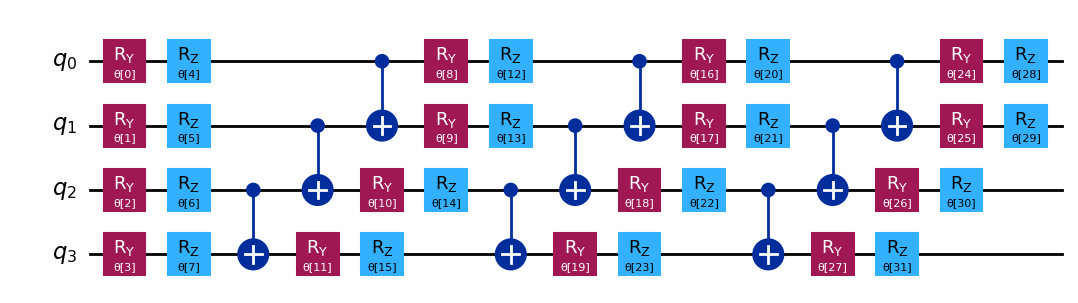

In [9]:
ansatz =  EfficientSU2(hamiltonian.num_qubits)
# Combine the initial state circuit with the ansatz circuit
#ansatz.append(ansatz, [0, 1])

# Measure the qubits
#qc.measure([0, 1], [0, 1])

ansatz.decompose().draw("mpl", style="iqp")



In [10]:
num_params = ansatz.num_parameters
num_params

32

In [11]:
# Run the sampler job locally using FakeManilaV2
fake_manila = FakeManilaV2()
target = fake_manila.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

# Transpile the ansatz for the backend
ansatz_isa = pm.run(ansatz)


In [12]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [13]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy


In [14]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [15]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([3.21998354, 0.4340435 , 2.86866184, 0.6001596 , 3.34301382,
       3.39377961, 5.16738083, 3.94584236, 3.87481348, 6.15230084,
       5.406318  , 4.71342996, 3.0176051 , 0.25415649, 0.43749895,
       1.32959974, 4.26405607, 3.21175436, 3.34242975, 2.79790617,
       4.18552903, 2.31642495, 3.14333896, 2.55707305, 5.43651296,
       2.09009481, 1.71849433, 4.95220317, 5.12563559, 2.71926244,
       2.40091822, 2.99397664])

In [16]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
estimator = Estimator()
sampler = Sampler()

In [17]:
# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

res = minimize(cost_func_vqe, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})

end_time = time.time()
execution_time = end_time - start_time

Iters. done: 1 [Current cost: -0.3640832384560076]
Iters. done: 2 [Current cost: -0.30781969174549234]
Iters. done: 3 [Current cost: -0.2845281612401944]
Iters. done: 4 [Current cost: -0.20818811434886617]
Iters. done: 5 [Current cost: -0.42995364763205524]
Iters. done: 6 [Current cost: -0.4307117427424204]
Iters. done: 7 [Current cost: -0.4183135102777838]
Iters. done: 8 [Current cost: -0.3993101691546025]
Iters. done: 9 [Current cost: -0.3895588139922976]
Iters. done: 10 [Current cost: -0.47031523026086797]
Iters. done: 11 [Current cost: 0.01608395811353277]
Iters. done: 12 [Current cost: -0.20954198801503543]
Iters. done: 13 [Current cost: -0.47734292156562647]
Iters. done: 14 [Current cost: -0.3047695805380334]
Iters. done: 15 [Current cost: -0.5136268703120932]
Iters. done: 16 [Current cost: -0.4716111654383651]
Iters. done: 17 [Current cost: -0.4365915428585737]
Iters. done: 18 [Current cost: -0.3776830594701202]
Iters. done: 19 [Current cost: -0.5558514409711419]
Iters. done: 20

In [18]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.117398638638773
       x: [ 3.106e+00  6.568e-02 ...  3.938e+00  4.824e+00]
    nfev: 1000
   maxcv: 0.0

In [19]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [20]:
cost_history_dict["iters"] == res.nfev

True

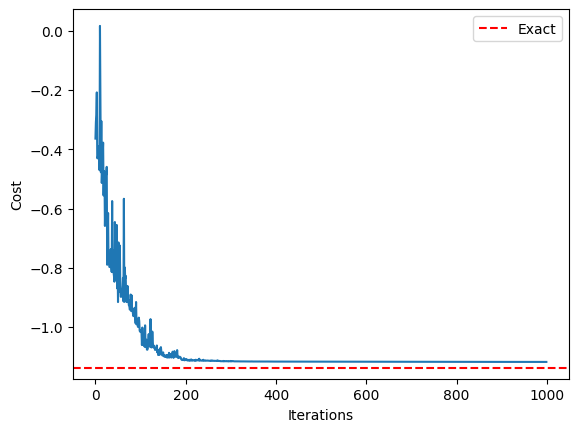

In [21]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

# Add a red horizontal line at 0.75 energy
ax.axhline(y=-1.13728383, color='red', linestyle='--', label="Exact")

# Add a label for the red line
ax.legend()

plt.draw()


In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from qiskit.primitives import StatevectorEstimator as Estimator, StatevectorSampler as Sampler

# Initialize the Qiskit Runtime service using your API token and custom URL
service = QiskitRuntimeService(
    channel="ibm_quantum",  # Can be either "ibm_quantum" or "ibm_cloud"
    token="d89ccdb0d55db78400c0370a7e592c9df75e3bc8e114ff2fefdda8c4c059162b0f0bf48c1d694e46c5963370b17676263020cc5e66d38d3a9358ae2121468840",
)

# Define the backend you want to use, e.g., "ibmq_brisbane"
backend = service.backend()


IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [ ]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 1000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )